# Vehicle Recall Predictions

# Required Code

This is the code required to load the datasets we need

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import re

data_path = 'data'
fields_path = 'fields'

# Written by: David
# Read and parse a file containing column names for a dataset.
# Returns a list of strings (the column names).
def load_column_names(columns_file_name):
    file = open(columns_file_name)
    column_names = []
    readingFields = False
    for line in file:
        if readingFields:
            if re.match('^[0-9]', line):
                split_line = line.split()
                column_names.append(split_line[1])
        elif line.startswith('Field#'):
            readingFields = True
    file.close()
    return column_names
#}

# Written by: David
# Load a dataest by its abbreviated names (ex: RCL).
def load_data_file(name, encoding):
    
    # Read the column names from a separate file.
    fields_file_name = fields_path + '/' + name + '.txt';
    names = load_column_names(fields_file_name)
    
    # Read the data from a CSV file.
    data_file_name = 'FLAT_' + name + '.txt';
    df = pd.read_csv(data_path + '/' + data_file_name,
                     delimiter='\t', header=None, encoding=encoding, names=names)
    
    return df
#}

print("done")

done


# Data cleaning for prediction

## Load the Complaints dataset

In [ ]:
# Load the complaints dataset.
# Only use a subset of the data (because there is a lot of it)
cmpl_train_df = load_data_file('CMPL', encoding='iso-8859-1')

## Filter and clean the Complaints dataset

In [ ]:
# Written by: David
# Create list of the columns we will use.
# --Christian added DATEA as numerical column
key_cols = ['MAKETXT', 'MODELTXT', 'YEARTXT','COMPDESC']
cat_cols = ['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE']
bool_cols = ['CRASH', 'FIRE', 'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
numer_cols = bool_cols + ['INJURED', 'DEATHS', 'MILES', 'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED','DATEA']
all_cols = key_cols + numer_cols + cat_cols

In [ ]:
# Written by: David
# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
clean_train_df = cmpl_train_df[(cmpl_train_df['MAKETXT'] != 'UNKNOWN') &
                   (cmpl_train_df['MODELTXT'] != 'UNKNOWN') &
                   (cmpl_train_df['YEARTXT'] > 1900) &
                   (cmpl_train_df['YEARTXT'] < 2020) &
                   (cmpl_train_df['PROD_TYPE'] == 'V')][all_cols + ['CMPLID']].copy()

# Written by: David
# Convert certain columns to a numerical data type.
clean_train_df['NUM_CYLS'] = pd.to_numeric(clean_train_df['NUM_CYLS'], errors='coerce')
clean_train_df['DATEA'] = pd.to_numeric(clean_train_df['DATEA'], errors='coerce')

# Written by: David
# Replace particular "bogus" values with NaN, which get filled later.
clean_train_df['INJURED'] = clean_train_df['INJURED'].replace(99, np.nan).fillna(0)
clean_train_df['DEATHS'] = clean_train_df['DEATHS'].replace(99, np.nan).fillna(0)

# Written by: David
# Clamp the values for specific numerical columns.
clean_train_df['NUM_CYLS'] = clean_train_df['NUM_CYLS'].clip(4, 8)
clean_train_df['MILES'] = clean_train_df['MILES'].clip(0, 300000)
clean_train_df['OCCURENCES'] = clean_train_df['OCCURENCES'].clip(1, 10)
clean_train_df['VEH_SPEED'] = clean_train_df['VEH_SPEED'].clip(0, 100)

# Written by: Christian
# Clean values in component descriptions
# Custom split function to pass to apply
def split(comp):
    if type(comp) != str:
        return ''
    return comp.split(':')[0]

# Written by: Christian
# Generalize the names of each component
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].apply(split)

# Written by: Christian
# Fix differences between component names in complaints and recalls
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('FUEL/PROPULSION SYSTEM','FUEL SYSTEM').replace('AIR BAG','AIR BAGS')
clean_train_df['COMPDESC'] = clean_train_df['COMPDESC'].replace('OTHER','').replace('UNKNOWN OR OTHER','')

# Written by: David
# Replace 'Y' and 'N' with 1 and 0 for boolean columns.
# Also convert them to numeric so we can average them.
# This will allow us to get a percentage of 'yes' for each vehicle type.
for column in bool_cols:
    clean_train_df[column] = clean_train_df[column].replace('Y', 1).replace('N', 0)
    clean_train_df[column] = pd.to_numeric(clean_train_df[column])

# Print out part of the resulting semi-clean data set
clean_train_df[all_cols].head(10)

## Group complaints by make/model/year and perform aggregate functions on the column values

Warning: this step takes a few minutes to perform all the aggregate functions

In [ ]:
# Written by: David
# Aggregate function which Returns the mode of a series.
# If there is no valid mode, but there are any amount of
# non-null values, then the first non-null value is returned.
# Otherwise, if all values are NaN, then NaN is returned
def aggMode(x):
    column_mode = x.mode()
    
    # If there is a valid mode, return it
    if column_mode.count() > 0:
        return column_mode[0]
   
    # if there are any non-null values, return one of them
    first_valid = x.first_valid_index()
    if first_valid != None:
        return x[first_valid]
    
    return np.nan
#}

In [ ]:
# Written by: David
# Group the dataset by the key columns (make/model/year/component)
grouped = clean_train_df.groupby(key_cols)

# Written by: David
# Perform aggregate functions on the columns for each vehicle type.
# Aggregate with the mode for categorical columns
# Aggregate with the mean for numerical columns
grouped_df = pd.DataFrame()
for col in cat_cols:
    grouped_df[col] = grouped[col].agg(aggMode)
for col in numer_cols:
    grouped_df[col] = grouped[col].mean()

# Written by: David
# Add in a column for the number of complaints for each vehicle-component.
grouped_df['COMPLAINTS'] = grouped.size()
numer_cols.append('COMPLAINTS');
all_cols.append('COMPLAINTS');

print('done')

## Replace missing values with the mean or mode for that column over the entire dataset

In [ ]:
# Written by: David

# Replace NaN with mode for categorical columns
for col in cat_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mode()[0])

# Replace NaN with mean for numerical columns
for col in numer_cols:
    grouped_df[col] = grouped_df[col].fillna(grouped_df[col].mean())

print('done')

In [ ]:
# Print out the grouped dataset.
grouped_df

## Check which vehicle types exist in the Recalls dataset

Warning: This is the longest step and it will take several minutes

In [ ]:
# Load the recall dataset
rcl_df = load_data_file('RCL', encoding='latin1');

In [ ]:
# Written by: Christian
# Rename the component field in recalls so it matches complaints
recalled_set = rcl_df.rename(columns = {'COMPNAME':'COMPDESC'})

# Written by: David
# Create the set of vehicle types from the recalled dataset.
# Filter out rows with invalid make, model, or year.
# Also filter out any non-vehicles.
#--Christian - switched to all columns, doesn't take much longer and makes next part easier
recalled_set = recalled_set[(rcl_df['MAKETXT'] != 'UNKNOWN') &
                      (rcl_df['MODELTXT'] != 'UNKNOWN') &
                      (rcl_df['YEARTXT'] > 1900) &
                      (rcl_df['YEARTXT'] < 2020) &
                      (rcl_df['RCLTYPECD'] == 'V')][recalled_set.columns.values].copy()

# Written by: Christian
# Generalize the names of each component
recalled_set['COMPDESC'] = recalled_set['COMPDESC'].apply(split)

# Convert Date to a numeric value
recalled_set['RCDATE'] = pd.to_numeric(recalled_set['RCDATE'], errors='coerce')


# Written by: David
# Make the recalled set only have unique vehicle types,
# mostly for efficiency in the next step.
recalled_set = recalled_set[key_cols + ["RCDATE"]].groupby(key_cols)
print("done")

In [ ]:
# Written by: Matt/Christian
# Now create the columns in the complaints set which says
# whether a vehicle type is in the recalled sets.
# --Christian - switched so it only counts as recalled if the recall happened after the complaint
# added whether or not the car was recalled within a period of time
# switched to a mix of integer and label indexing for accuracy purposes
grouped_df['RECALLED'] = False
grouped_df['RECALLED_1YR'] = False
grouped_df['RECALLED_3YR'] = False
grouped_df['RECALLED_5YR'] = False
for int_index in range(len(grouped_df)):
    #get the old label based index aka key_cols
    index = grouped_df.iloc[int_index].name
    #key exists in recalls
    if(index in recalled_set.indices):
        #list of all recall dates YYYYMMDD format
        recalled_dates = recalled_set.get_group(index)["RCDATE"].get_values()
        #date of current recall
        comp_date = grouped_df.iloc[int_index]["DATEA"]
        for rcl_date in recalled_dates:
            if comp_date < rcl_date:
                grouped_df.ix[int_index,'RECALLED'] = True
                if comp_date + 50000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_5YR"] = True
                if comp_date + 30000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_3YR"] = True
                if comp_date + 10000 > rcl_date:
                    grouped_df.ix[int_index,"RECALLED_1YR"] = True
print(grouped_df['RECALLED'].value_counts())
print(grouped_df['RECALLED_5YR'].value_counts())
print(grouped_df['RECALLED_3YR'].value_counts())
print(grouped_df['RECALLED_1YR'].value_counts())


In [ ]:
grouped_df.loc[grouped_df['RECALLED'] == True]

## Save grouped data to a CSV file

In [ ]:
grouped_df.to_csv("fullData.txt")

# Random Decision Forest Prediction

## Import required libraries

In [2]:
# Written by: Matt
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## Load grouped data from the CSV file

In [3]:
# Load the grouped data from file
grouped_df = pd.read_csv('fullData.txt', index_col=[0,1,2,3])

# Written by: David
# Create list of the columns we will use.
# --Christian added DATEA as numerical column
key_cols = ['MAKETXT', 'MODELTXT', 'YEARTXT','COMPDESC']
cat_cols = ['DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE', 'TRANS_TYPE']
bool_cols = ['CRASH', 'FIRE', 'POLICE_RPT_YN', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN', 'CRUISE_CONT_YN', 'MEDICAL_ATTN', 'VEHICLES_TOWED_YN']
numer_cols = bool_cols + ['INJURED', 'DEATHS', 'MILES', 'OCCURENCES', 'NUM_CYLS', 'VEH_SPEED','DATEA']
all_cols = key_cols + numer_cols + cat_cols
numer_cols.append('COMPLAINTS')
all_cols.append('COMPLAINTS')

print('done')

done


## Prepare data for training and validation

In [4]:
# Function to grab 'n' number of random samples from a dataframe 'x'
import random
def some(x, n):
    return x.ix[random.sample(set(x.index), n)]

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData = some(recalledSamples, numSamples)
fullData = fullData.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_5YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_5YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_5yr = some(recalledSamples, numSamples)
fullData_5yr = fullData_5yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_3YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_3YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_3yr = some(recalledSamples, numSamples)
fullData_3yr = fullData_3yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

# Split the data frame by the recalled values.
recalledSamples = grouped_df[grouped_df['RECALLED_1YR'] == True];
nonRecalledSamples = grouped_df[grouped_df['RECALLED_1YR'] == False];

# Grab an equal number of random samples from each set.
numSamples = min(recalledSamples.shape[0], nonRecalledSamples.shape[0])
fullData_1yr = some(recalledSamples, numSamples)
fullData_1yr = fullData_1yr.append(some(nonRecalledSamples, numSamples))

print('Gathered', numSamples, 'recalled components and',
      numSamples, 'non-recalled components')

Gathered 3996 recalled components and 3996 non-recalled components
Gathered 3686 recalled components and 3686 non-recalled components
Gathered 3266 recalled components and 3266 non-recalled components
Gathered 1983 recalled components and 1983 non-recalled components


In [5]:
# Written by: David
# Drop columns that have missing values. Our previous
# steps would have filled all missing values UNLESS
# the column is entirely filled with null. Therefore,
# just drop columns that are null, they don't tell us anything.
for col in cat_cols + numer_cols:
    if fullData[col].isnull().any():
        print('Dropping column ', col)
        fullData.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_5yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_5yr.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_3yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_3yr.drop(col, axis=1,inplace=True)
for col in cat_cols + numer_cols:
    if fullData_1yr[col].isnull().any():
        print('Dropping column ', col)
        fullData_1yr.drop(col, axis=1,inplace=True)

# Written by: Matt
# Create label encoders for categorical features
for var in cat_cols:
    number = LabelEncoder()
    fullData[var] = number.fit_transform(fullData[var].astype('str'))
    fullData_5yr[var] = number.fit_transform(fullData_5yr[var].astype('str'))
    fullData_3yr[var] = number.fit_transform(fullData_3yr[var].astype('str'))
    fullData_1yr[var] = number.fit_transform(fullData_1yr[var].astype('str'))

# Written by: Matt
# Target variable is also a categorical so convert it
fullData['RECALLED'] = number.fit_transform(fullData['RECALLED'].astype('str'))
fullData_5yr['RECALLED_5YR'] = number.fit_transform(fullData_5yr['RECALLED_5YR'].astype('str'))
fullData_3yr['RECALLED_3YR'] = number.fit_transform(fullData_3yr['RECALLED_3YR'].astype('str'))
fullData_1yr['RECALLED_1YR'] = number.fit_transform(fullData_1yr['RECALLED_1YR'].astype('str'))

# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData['is_train'] = np.random.uniform(0, 1, len(fullData)) <= .75
Train, Validate = fullData[fullData['is_train']==True], fullData[fullData['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])
print()

Training set size = 5977
Validation set size = 2015



# Run Testing for Recalled target

In [6]:
# Written by: Matt
# Get a list of the defining features.
features = list(set(list(fullData.columns)) - set(['RECALLED','RECALLED_5YR','RECALLED_1YR','RECALLED_3YR']))

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED'].values

## Calculate and plot the ROC Curve

In [7]:
# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

Area under ROC curve = 0.767083545172


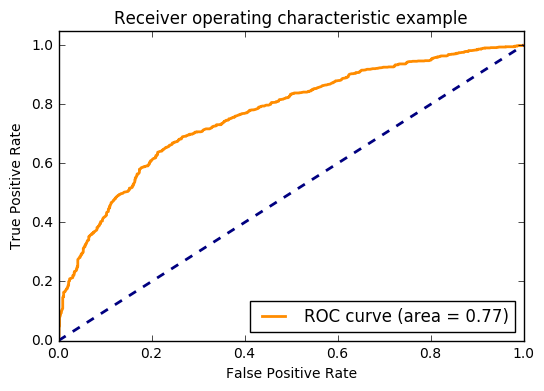

In [8]:
# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

## Calculate the Confusion Matrix

In [9]:
# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')


confusion matrix:
[[726 293]
 [300 696]]

726  non-recalled cars were predicted to be not recalled
293  non-recalled cars were predicted to be recalled
300  recalled cars were predicted to be not recalled
696  recalled cars were predicted to be recalled


## Calculate the Accuracy & Mean Squared Error

In [10]:
# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

accuracy = 0.70570719603
Mean squared error = 0.29429280397


# Run Testing for Recalled within five year target

Training set size = 5551
Validation set size = 1821
Area under ROC curve = 0.778766655649


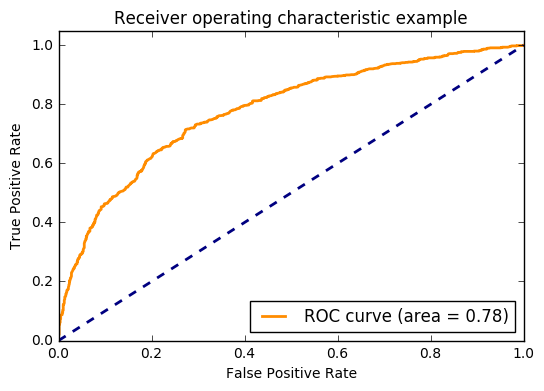

confusion matrix:
[[641 266]
 [250 664]]

641  non-recalled cars were predicted to be not recalled
266  non-recalled cars were predicted to be recalled
250  recalled cars were predicted to be not recalled
664  recalled cars were predicted to be recalled
accuracy = 0.716639209226
Mean squared error = 0.283360790774


In [11]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_5yr['is_train'] = np.random.uniform(0, 1, len(fullData_5yr)) <= .75
Train, Validate = fullData_5yr[fullData_5yr['is_train']==True], fullData_5yr[fullData_5yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED_5YR'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_5YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

# Run Testing for Recalled within three year target

Training set size = 4834
Validation set size = 1698
Area under ROC curve = 0.90644581532


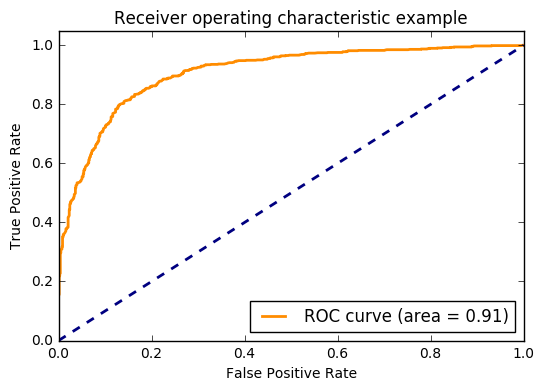

confusion matrix:
[[643 190]
 [ 99 766]]

643  non-recalled cars were predicted to be not recalled
190  non-recalled cars were predicted to be recalled
99  recalled cars were predicted to be not recalled
766  recalled cars were predicted to be recalled
accuracy = 0.829799764429
Mean squared error = 0.170200235571


In [12]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_3yr['is_train'] = np.random.uniform(0, 1, len(fullData_3yr)) <= .75
Train, Validate = fullData_3yr[fullData_3yr['is_train']==True], fullData_3yr[fullData_3yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_3YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))

# Run Testing for 1 year target

Training set size = 2977
Validation set size = 989
Area under ROC curve = 0.790030841726


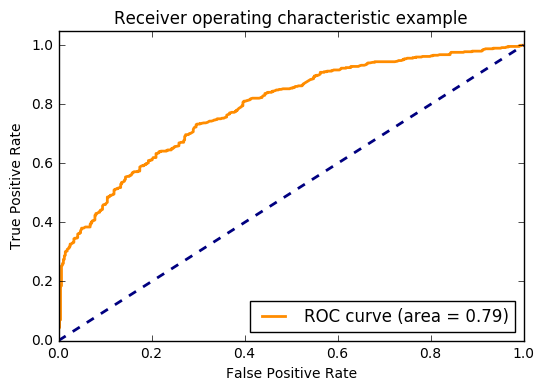

confusion matrix:
[[351 136]
 [152 350]]

351  non-recalled cars were predicted to be not recalled
136  non-recalled cars were predicted to be recalled
152  recalled cars were predicted to be not recalled
350  recalled cars were predicted to be recalled
accuracy = 0.708796764408
Mean squared error = 0.291203235592


In [13]:
# Written by: Matt
# Split train dataset into train and validation sub-sets
fullData_1yr['is_train'] = np.random.uniform(0, 1, len(fullData_1yr)) <= .75
Train, Validate = fullData_1yr[fullData_1yr['is_train']==True], fullData_1yr[fullData_1yr['is_train']==False]

print('Training set size =', Train.shape[0])
print('Validation set size =', Validate.shape[0])

# Written by: Matt
x_train = Train[list(features)].values
y_train = Train['RECALLED_1YR'].values
x_validate = Validate[list(features)].values
y_validate = Validate['RECALLED_1YR'].values

# Written by: Matt
# Create the random forest classifier
random.seed(100)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train, y_train)

# Written by: Matt
# Predict the probablies of recalls for the validation set.
status = rf.predict_proba(x_validate)

# Written by: Matt
# Calculate the ROC curve and Area under the curve.
fpr, tpr, _ = roc_curve(y_validate, status[:,1])
roc_auc = auc(fpr, tpr)
print('Area under ROC curve =', roc_auc)

# Written by: Matt
# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Written by: David

# Get a list of the actual recalled states.
y_true = y_validate

# Get a list of the predicted recalled states.
# The status array holds probabilities whether something is recalled
y_pred = np.array([(item[1] >= 0.5) for item in status]).astype(int)

# Calculate the confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print('confusion matrix:')
print(cnf_matrix)

# Now print out what it MEANS:
print()
print(cnf_matrix[0][0], ' non-recalled cars were predicted to be not recalled')
print(cnf_matrix[0][1], ' non-recalled cars were predicted to be recalled')
print(cnf_matrix[1][0], ' recalled cars were predicted to be not recalled')
print(cnf_matrix[1][1], ' recalled cars were predicted to be recalled')

# Written by: David

print('accuracy =', accuracy_score(y_true, y_pred))
print('Mean squared error =', mean_squared_error(y_true, y_pred))